In [1]:
from utils.preprocessing import DataLoader
import gurobipy as gp
from gurobipy import *

# 数据读取

In [2]:
data_loader = DataLoader('data/Data A-Crew.csv', 'data/Data A-Flight.csv')

In [3]:
data_loader.dumpdata()

Counting times...(0/206)
Counting times...(100/206)
Counting times...(200/206)
## Loading C
## C loaded
## Loading AP
## AP loaded
## Loading Base
## Base loaded
## Loading F
## F loaded
## Loading FF
Loading data... (10000/42436)
Loading data... (20000/42436)
Loading data... (30000/42436)
Loading data... (40000/42436)
## FF loaded
## Loading FF1
Loading data... (10000/42436)
Loading data... (20000/42436)
Loading data... (30000/42436)
Loading data... (40000/42436)
## FF1 loaded
## Loading FF2
Loading data... (10000/42436)
Loading data... (20000/42436)
Loading data... (30000/42436)
Loading data... (40000/42436)
## FF2 loaded
Counting times...(0/206)
Counting times...(100/206)
Counting times...(200/206)


In [4]:
data_loader_a1 = DataLoader('data/Data A-Crew.csv', 'data/Data A-Flight.csv')

In [5]:
data_loader_a1.dump_data(cropped_date=(11,18))

Counting times...(0/108)
Counting times...(100/108)
## Loading C
## C loaded
## Loading AP
## AP loaded
## Loading Base
## Base loaded
## Loading F
## F loaded
## Loading FF
Loading data... (10000/11664)
## FF loaded
## Loading FF1
Loading data... (10000/11664)
## FF1 loaded
## Loading FF2
Loading data... (10000/11664)
## FF2 loaded
Counting times...(0/108)
Counting times...(100/108)


# 模型建立与求解

## 第一阶段

### 优化目标①

In [6]:
m=gp.Model('m1')

z=m.addVars(data_loader_a1.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='r_jkfin')
d_iksta=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='d_iksta')
d_jkfin=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='d_jkfin')

y_ijk=m.addVars(data_loader_a1.F,data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='y_ijk')
v_ijk=m.addVars(data_loader_a1.F,data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='v_ijk')

m.ModelSense=GRB.MINIMIZE

m.setObjective(-z.sum())

M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a1.F for k in data_loader_a1.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a1.F for k in data_loader_a1.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a1.F for k in data_loader_a1.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a1.C)<=M*(z[i]) for i in data_loader_a1.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a1.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a1.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a1.C) for j in data_loader_a1.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a1.FF for k in data_loader_a1.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
# m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a.nonF_arrive_base[0] for k in data_loader_a.C)
m.addConstrs(r_iksta[i,k]== 0 for i in data_loader_a1.nonF_leave_base[0] for k in data_loader_a1.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a1.F_leave_base[0] )<=1  for k in data_loader_a1.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a1.F )-gp.quicksum(r_iksta[i,k] for i in data_loader_a1.F_leave_base[0] ) == 0 for k in data_loader_a1.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a1.F for k in data_loader_a1.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a1.F for k in data_loader_a1.C)

#第二问
#对V的约束
m.addConstrs(v_ijk[i,j,k]==0 for i,j in data_loader_a1.FF1 for k in data_loader_a1.C)
m.addConstrs(v_ijk[i,j,k] <= y_ijk[i,j,k] for i in data_loader_a1.F for j in data_loader_a1.F for k in data_loader_a1.C)


#对duty执勤的约束
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t]) - gp.quicksum(d_jkfin[i,k] for i in data_loader_a1.FD[t]) == 0 for i in data_loader_a1.F for k in data_loader_a1.C for t in data_loader_a1.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t])   <= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a1.FD[t]) for i in data_loader_a1.F for k in data_loader_a1.C for t in data_loader_a1.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t])*M >= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a1.FD[t]) for k in data_loader_a1.C for t in data_loader_a1.Dates)


#第二问中航班对应执勤，执勤对应周期的约束
m.addConstrs((v_ijk.sum(i,'*',k)+ r_jkfin[i,k] ==  d_jkfin[i,k]) for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs((v_ijk.sum('*',i,k)+ r_iksta[i,k] ==  d_iksta[i,k]) for i in data_loader_a1.F for k in data_loader_a1.C)



#第二问中其余约束
m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) <= 720 for k in data_loader_a1.C for t in data_loader_a1.Dates )
m.addConstrs(gp.quicksum((x_ikcap[i,k]+x_ikfo[i,k])*(data_loader_a1.leavetime[i]-data_loader_a1.arrivetime[i]) for i in data_loader_a1.FD[t]) <= 600 for k in data_loader_a1.C for t in data_loader_a1.Dates )



# m.addConstr(z.sum('*')==108)
# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) 
#                                                            - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]))
#                                                            for k in data_loader_a1.C) for t in data_loader_a1.Dates )==[16900000,17000000])

# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t])) 
#                     - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t])
#                 for k in data_loader_a1.C) for t in data_loader_a1.Dates) <= 170000000)
#对执勤时长平衡的约束（辅助目标）
# m.addConstrs(a1>=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates)) for k in data_loader_a1.C)
# m.addConstrs(a2<=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates)) for k in data_loader_a1.C)
#m.addConstr(a2 >= 0)
# m.addContr(z.sum()==108)

m.update()
# m.setParam("MIPGap", )
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 723381 rows, 505872 columns and 4185966 nonzeros
Model fingerprint: 0x37c7560e
Variable types: 0 continuous, 505872 integer (505872 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 0.0000000
Presolve removed 679179 rows and 428352 columns
Presolve time: 4.43s
Presolved: 44202 rows, 77520 columns, 329280 nonzeros
Variable types: 0 continuous, 77520 integer (77520 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    2987   -4.0530079e+00   0.000000e+00   3.1942

### 联合优化目标②④⑦

In [7]:
m=gp.Model('m1')

z=m.addVars(data_loader_a1.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='r_jkfin')
d_iksta=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='d_iksta')
d_jkfin=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='d_jkfin')

y_ijk=m.addVars(data_loader_a1.F,data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='y_ijk')
v_ijk=m.addVars(data_loader_a1.F,data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='v_ijk')

# a1=m.addVar(1,vtype=gp.GRB.INTEGER,name='a1')
# a2=m.addVar(2,vtype=gp.GRB.INTEGER,name='a2')

m.ModelSense=GRB.MINIMIZE


# m.setObjectiveN(expr, index=0,pririty=1)
# m.setObjectiveN(-z.sum())
m.setObjectiveN(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) 
                                                          - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]))/60
                                                          for k in data_loader_a1.C) for t in data_loader_a1.Dates ),index=0,priority=8)

m.setObjectiveN(x_ikdh.sum(),index=1,priority=7)
m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a1.F for k in data_loader_a1.C2), index=2, priority=6)

# m.setObjectiveN(a1-a2,index=3,priority=5)

# m.setObjectiveN(-z.sum(),index = 0,weight =0.8)
# m.setObjectiveN(x_ikdh.sum(),index=1,weight=0.2)
# m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2),index=2,weight=0.05)


M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a1.F for k in data_loader_a1.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a1.F for k in data_loader_a1.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a1.F for k in data_loader_a1.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a1.C)<=M*(z[i]) for i in data_loader_a1.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a1.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a1.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a1.C) for j in data_loader_a1.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a1.FF for k in data_loader_a1.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
# m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a.nonF_arrive_base[0] for k in data_loader_a.C)
m.addConstrs(r_iksta[i,k]== 0 for i in data_loader_a1.nonF_leave_base[0] for k in data_loader_a1.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a1.F_leave_base[0] )<=1  for k in data_loader_a1.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a1.F )-gp.quicksum(r_iksta[i,k] for i in data_loader_a1.F_leave_base[0] ) == 0 for k in data_loader_a1.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a1.F for k in data_loader_a1.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a1.F for k in data_loader_a1.C)

#第二问
#对V的约束
m.addConstrs(v_ijk[i,j,k]==0 for i,j in data_loader_a1.FF1 for k in data_loader_a1.C)
m.addConstrs(v_ijk[i,j,k] <= y_ijk[i,j,k] for i in data_loader_a1.F for j in data_loader_a1.F for k in data_loader_a1.C)


#对duty执勤的约束
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t]) - gp.quicksum(d_jkfin[i,k] for i in data_loader_a1.FD[t]) == 0 for i in data_loader_a1.F for k in data_loader_a1.C for t in data_loader_a1.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t])   <= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a1.FD[t]) for i in data_loader_a1.F for k in data_loader_a1.C for t in data_loader_a1.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t])*M >= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a1.FD[t]) for k in data_loader_a1.C for t in data_loader_a1.Dates)

#m.addConstrs(d_iksta[i,k] for i in data_loader_a.FD[t]  <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a.FD[t] for k in data_loader_a.C for t in data_loader_a.Dates)

#第二问中航班对应执勤，执勤对应周期的约束
m.addConstrs((v_ijk.sum(i,'*',k)+ r_jkfin[i,k] ==  d_jkfin[i,k]) for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs((v_ijk.sum('*',i,k)+ r_iksta[i,k] ==  d_iksta[i,k]) for i in data_loader_a1.F for k in data_loader_a1.C)

#m.addConstrs((d_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)
#m.addConstrs((d_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)

#第二问中其余约束
m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) <= 720 for k in data_loader_a1.C for t in data_loader_a1.Dates )
m.addConstrs(gp.quicksum((x_ikcap[i,k]+x_ikfo[i,k])*(data_loader_a1.leavetime[i]-data_loader_a1.arrivetime[i]) for i in data_loader_a1.FD[t]) <= 600 for k in data_loader_a1.C for t in data_loader_a1.Dates )
#m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) >= 0 for k in data_loader_a.C for t in data_loader_a.Dates )


# m.addConstr(z.sum('*')==108)
# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) 
#                                                            - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]))
#                                                            for k in data_loader_a1.C) for t in data_loader_a1.Dates )==[16900000,17000000])

# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t])) 
#                     - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t])
#                 for k in data_loader_a1.C) for t in data_loader_a1.Dates) <= 170000000)
#对执勤时长平衡的约束（辅助目标）
# m.addConstrs(a1>=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates)) for k in data_loader_a1.C)
# m.addConstrs(a2<=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates)) for k in data_loader_a1.C)
#m.addConstr(a2 >= 0)
m.addConstr(z.sum()==108)

m.update()
# m.setParam("MIPGap", 0.0176)
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 723382 rows, 505872 columns and 4186074 nonzeros
Model fingerprint: 0xf632c5bc
Variable types: 0 continuous, 505872 integer (505872 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 680662 rows and 429834 columns
Presolve time: 4.34s
Presolved: 42720 rows and 76038 columns
---------------------------------------------------------------------------

Multi-objectives:

Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.826250e+02   1.385697e+10    313s
   25548    0.0000000e+00   9.969016e+01   1.845134e+10    315s
   68492    0.0000000e+00   6.517974e+01   8.680828e+09    320s
   99846    0.0000000e+00   5.441076e+01   2.225862e+10    325s
  120098    0.0000000e+00   4.897877e+01   9.441546e+09    330s
  139496    0.0000000e+00   4.517301e+01   3.335398e+10    335s
  157796    0.0000000e+00   4.135000e+01   1.246388e+10    340s
  172436    0.0000000e+00   3.615829e+01   1.915395e+10    345s
  186710    0.0000000e+00   3.283403e+01   9.233142e+09    350s
  201106    0.0000000e+00   2.911742e+01   1.827741e+10    355s
  214648    0.0000000e+00   2.448050e+01   9.956290e+09    360s
  228068    0.0000000e+00   2.082505e+01   9.846483e+10    365s
  242098    0.0000000e+00   1.777436e+01   8.756247e+09    370s
  255762    0.0000000e+00   1.607579e+01   7.452648e+09

### 优化目标⑤

In [8]:
m=gp.Model('m1')

z=m.addVars(data_loader_a1.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='r_jkfin')
d_iksta=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='d_iksta')
d_jkfin=m.addVars(data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='d_jkfin')

y_ijk=m.addVars(data_loader_a1.F,data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='y_ijk')
v_ijk=m.addVars(data_loader_a1.F,data_loader_a1.F,data_loader_a1.C,vtype=gp.GRB.BINARY,name='v_ijk')

a1=m.addVar(1,vtype=gp.GRB.INTEGER,name='a1')
a2=m.addVar(2,vtype=gp.GRB.INTEGER,name='a2')

m.ModelSense=GRB.MINIMIZE


# m.setObjectiveN(expr, index=0,pririty=1)
# m.setObjectiveN(-z.sum())
# m.setObjectiveN(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) 
#                                                           - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]))/60
#                                                           for k in data_loader_a1.C) for t in data_loader_a1.Dates ),index=0,priority=8)

# m.setObjectiveN(x_ikdh.sum(),index=1,priority=7)
# m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a1.F for k in data_loader_a1.C2), index=2, priority=6)

m.setObjective(a1-a2)

# m.setObjectiveN(-z.sum(),index = 0,weight =0.8)
# m.setObjectiveN(x_ikdh.sum(),index=1,weight=0.2)
# m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2),index=2,weight=0.05)


M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a1.F for k in data_loader_a1.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a1.F for k in data_loader_a1.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a1.F for k in data_loader_a1.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a1.C)<=M*(z[i]) for i in data_loader_a1.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a1.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a1.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a1.C) for j in data_loader_a1.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a1.FF for k in data_loader_a1.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
# m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a.nonF_arrive_base[0] for k in data_loader_a.C)
m.addConstrs(r_iksta[i,k]== 0 for i in data_loader_a1.nonF_leave_base[0] for k in data_loader_a1.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a1.F_leave_base[0] )<=1  for k in data_loader_a1.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a1.F )-gp.quicksum(r_iksta[i,k] for i in data_loader_a1.F_leave_base[0] ) == 0 for k in data_loader_a1.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a1.F for k in data_loader_a1.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a1.F for k in data_loader_a1.C)

#第二问
#对V的约束
m.addConstrs(v_ijk[i,j,k]==0 for i,j in data_loader_a1.FF1 for k in data_loader_a1.C)
m.addConstrs(v_ijk[i,j,k] <= y_ijk[i,j,k] for i in data_loader_a1.F for j in data_loader_a1.F for k in data_loader_a1.C)


#对duty执勤的约束
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t]) - gp.quicksum(d_jkfin[i,k] for i in data_loader_a1.FD[t]) == 0 for i in data_loader_a1.F for k in data_loader_a1.C for t in data_loader_a1.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t])   <= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a1.FD[t]) for i in data_loader_a1.F for k in data_loader_a1.C for t in data_loader_a1.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a1.FD[t])*M >= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a1.FD[t]) for k in data_loader_a1.C for t in data_loader_a1.Dates)

#m.addConstrs(d_iksta[i,k] for i in data_loader_a.FD[t]  <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a.FD[t] for k in data_loader_a.C for t in data_loader_a.Dates)

#第二问中航班对应执勤，执勤对应周期的约束
m.addConstrs((v_ijk.sum(i,'*',k)+ r_jkfin[i,k] ==  d_jkfin[i,k]) for i in data_loader_a1.F for k in data_loader_a1.C)
m.addConstrs((v_ijk.sum('*',i,k)+ r_iksta[i,k] ==  d_iksta[i,k]) for i in data_loader_a1.F for k in data_loader_a1.C)

#m.addConstrs((d_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)
#m.addConstrs((d_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)

#第二问中其余约束
m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) <= 720 for k in data_loader_a1.C for t in data_loader_a1.Dates )
m.addConstrs(gp.quicksum((x_ikcap[i,k]+x_ikfo[i,k])*(data_loader_a1.leavetime[i]-data_loader_a1.arrivetime[i]) for i in data_loader_a1.FD[t]) <= 600 for k in data_loader_a1.C for t in data_loader_a1.Dates )
#m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) >= 0 for k in data_loader_a.C for t in data_loader_a.Dates )


# m.addConstr(z.sum('*')==108)
# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) 
#                                                            - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]))
#                                                            for k in data_loader_a1.C) for t in data_loader_a1.Dates )==[16900000,17000000])

# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t])) 
#                     - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t])
#                 for k in data_loader_a1.C) for t in data_loader_a1.Dates) <= 170000000)
#对执勤时长平衡的约束（辅助目标）
m.addConstrs(a1>=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates)) for k in data_loader_a1.C)
m.addConstrs(a2<=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]) for t in data_loader_a1.Dates)) for k in data_loader_a1.C)
#m.addConstr(a2 >= 0)
m.addConstr(z.sum()==108)
m.addConstr(gp.quicksum(gp.quicksum(data_loader_a1.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a1.arrivetime[i] for i in data_loader_a1.FD[t]) 
                                                          - gp.quicksum(d_iksta[i,k]*data_loader_a1.leavetime[i] for i in data_loader_a1.FD[t]))/60
                                                          for k in data_loader_a1.C) for t in data_loader_a1.Dates) == 282710)
m.addConstr(x_ikdh.sum()==15)
m.addConstr(gp.quicksum(x_ikfo[i,k] for i in data_loader_a1.F for k in data_loader_a1.C2)==0)

m.update()
m.setParam("MIPGap", 0.0176)
m.optimize()

Set parameter MIPGap to value 0.0176
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 723427 rows, 505874 columns and 4202577 nonzeros
Model fingerprint: 0x4a84fd8c
Variable types: 0 continuous, 505874 integer (505872 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 3e+05]
Presolve removed 678731 rows and 428550 columns
Presolve time: 3.82s
Presolved: 44696 rows, 77324 columns, 337995 nonzeros
Variable types: 0 continuous, 77324 integer (77322 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   17205    0.0000000e+00   1.691451e+02   2.743952e+10      5s
   68000    0.0000000e+00   7.159333e+01   8.053354e+09     10s
   93965    0.0000000

H    0     0                     985.0000000  909.00000  7.72%     -  555s
     0     0  909.00000    0  227  985.00000  909.00000  7.72%     -  555s
     0     0  909.00000    0  227  985.00000  909.00000  7.72%     -  556s
H    0     2                     980.0000000  909.00000  7.24%     -  558s
     0     2  909.00000    0  227  980.00000  909.00000  7.24%     -  558s
     1     4  909.00000    1  252  980.00000  909.00000  7.24%  5344  564s
     3     8  909.00000    2  378  980.00000  909.00000  7.24%  2505  568s
    15    24  909.00000    4  381  980.00000  909.00000  7.24%  1037  571s
    47    60  909.00000    6  332  980.00000  909.00000  7.24%  1031  575s
   113   138  909.00000   13  372  980.00000  909.00000  7.24%   603  581s
H  136   138                     960.0000000  909.00000  5.31%   535  581s
   252   281  948.00000   24  227  960.00000  909.00000  5.31%   398  587s
   338   417  948.00000   10  165  960.00000  909.00000  5.31%   333  595s
   590   453  953.52172  

## 为第二阶段准备数据

In [9]:
results_dic = {'em_no':[], 'fl_no':[], 'cls':[]}
for i in data_loader_a1.F:
    for k in data_loader_a1.C:
        if x_ikcap[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a1.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(1)
        if x_ikfo[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a1.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(2)
        if x_ikdh[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a1.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(3)

In [10]:
for i in data_loader_a1.F:
    for k in data_loader_a1.C:
        if x_ikcap[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a1.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(1)
        if x_ikfo[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a1.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(2)
        if x_ikdh[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a1.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(3)

In [11]:
leave_temp_base = {}
arrive_time_skipping = {}
for k in data_loader_a1.C:
    for i in data_loader_a1.F:
        if r_jkfin[i,k].x > 0.9:
            leave_temp_base[k] = data_loader_a1.AP_dic[data_loader_a1.F_ap_arr_dic[i]]
            arrive_time_skipping[k] =  data_loader_a1.arrivetime[i] - (24*60*(19-1) - data_loader_a1.get_min_time())

In [12]:
data_loader_a2 = DataLoader('data/Data A-Crew.csv', 'data/Data A-Flight.csv')

In [13]:
data_loader_a2.dump_data(cropped_date=(19,25))

Counting times...(0/98)
## Loading C
## C loaded
## Loading AP
## AP loaded
## Loading Base
## Base loaded
## Loading F
## F loaded
## Loading FF
## FF loaded
## Loading FF1
## FF1 loaded
## Loading FF2
## FF2 loaded
Counting times...(0/98)


In [14]:
for k in data_loader_a2.C:
    for key, value in data_loader_a2.AP_dic.items():
        if value == leave_temp_base[k]:
            leave_temp_base[k] = key
            break

In [15]:
leave_temp_base_dic = {}
MinRest = 660
for k in data_loader_a2.C:
    for i in data_loader_a2.F:
        if ((data_loader_a2.F_ap_dpt_dic[i] == leave_temp_base[k]) and ((data_loader_a2.leavetime[i]+data_loader_a2.get_min_time()-data_loader_a1.get_min_time() - arrive_time_skipping[k])>=MinRest)):#不是到达的机场
            if k not in leave_temp_base_dic.keys(): 
                leave_temp_base_dic[k] = [i]
            else:
                leave_temp_base_dic[k].append(i)

## 第二阶段

### 优化目标①

In [16]:
m=gp.Model('m1')

z=m.addVars(data_loader_a2.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='r_jkfin')
d_iksta=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='d_iksta')
d_jkfin=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='d_jkfin')

y_ijk=m.addVars(data_loader_a2.F,data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='y_ijk')
v_ijk=m.addVars(data_loader_a2.F,data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='v_ijk')

# a1=m.addVar(1,vtype=gp.GRB.INTEGER,name='a1')
# a2=m.addVar(2,vtype=gp.GRB.INTEGER,name='a2')

m.ModelSense=GRB.MINIMIZE

m.setObjective(-z.sum())

#m.setObjective(x_ikdh.sum())
# m.setObjective(gp.quicksum(x_ikfo[i,k] for i in F for k in C2))
# m.setObjective(gp.quicksum(gp.quicksum(data_loader_a.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) 
#                                                                - gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]))/60
#                                                            for k in data_loader_a.C) for t in data_loader_a.Dates ))
# m.setObjective(a1-a2)

#m.setObjectiveN(-z.sum(),index = 0,weight =0.8)
#m.setObjectiveN(x_ikdh.sum(),index=1,weight=0.2)
#m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2),index=2,weight=0.05)


M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a2.F for k in data_loader_a2.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a2.F for k in data_loader_a2.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a2.F for k in data_loader_a2.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a2.C)<=M*(z[i]) for i in data_loader_a2.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a2.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a2.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a2.C) for j in data_loader_a2.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a2.FF for k in data_loader_a2.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a2.nonF_arrive_base[0] for k in data_loader_a2.C)
# m.addConstrs(r_iksta[i,k]== 0 for i in non_leave_temp_base[k] for k in data_loader_a2.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a2.F )<=1  for k in data_loader_a2.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a2.F )-gp.quicksum(r_iksta[i,k] for i in leave_temp_base_dic[k] ) == 0 for k in data_loader_a2.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a2.F for k in data_loader_a2.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a2.F for k in data_loader_a2.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a2.F for k in data_loader_a2.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a2.F for k in data_loader_a2.C)

#第二问
#对V的约束
m.addConstrs(v_ijk[i,j,k]==0 for i,j in data_loader_a2.FF1 for k in data_loader_a2.C)
m.addConstrs(v_ijk[i,j,k] <= y_ijk[i,j,k] for i in data_loader_a2.F for j in data_loader_a2.F for k in data_loader_a2.C)


#对duty执勤的约束
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a2.FD[t]) - gp.quicksum(d_jkfin[i,k] for i in data_loader_a2.FD[t]) == 0 for i in data_loader_a2.F for k in data_loader_a2.C for t in data_loader_a2.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a2.FD[t])   <= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a2.FD[t]) for i in data_loader_a2.F for k in data_loader_a2.C for t in data_loader_a2.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a2.FD[t])*M >= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a2.FD[t]) for k in data_loader_a2.C for t in data_loader_a2.Dates)

#m.addConstrs(d_iksta[i,k] for i in data_loader_a.FD[t]  <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a.FD[t] for k in data_loader_a.C for t in data_loader_a.Dates)

#第二问中航班对应执勤，执勤对应周期的约束
m.addConstrs((v_ijk.sum(i,'*',k)+ r_jkfin[i,k] ==  d_jkfin[i,k]) for i in data_loader_a2.F for k in data_loader_a2.C)
m.addConstrs((v_ijk.sum('*',i,k)+ r_iksta[i,k] ==  d_iksta[i,k]) for i in data_loader_a2.F for k in data_loader_a2.C)

#m.addConstrs((d_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)
#m.addConstrs((d_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)

#第二问中其余约束
m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a2.arrivetime[i] for i in data_loader_a2.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a2.leavetime[i] for i in data_loader_a2.FD[t]) <= 720 for k in data_loader_a2.C for t in data_loader_a2.Dates )
m.addConstrs(gp.quicksum((x_ikcap[i,k]+x_ikfo[i,k])*(data_loader_a2.leavetime[i]-data_loader_a2.arrivetime[i]) for i in data_loader_a2.FD[t]) <= 600 for k in data_loader_a2.C for t in data_loader_a2.Dates )
#m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) >= 0 for k in data_loader_a.C for t in data_loader_a.Dates )


#m.addConstr(z.sum('*')==206)
# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) 
#                     - gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]))
#                 for k in data_loader_a.C) for t in data_loader_a.Dates )==[1324573-100000,1324573+100000])
#对执勤时长平衡的约束（辅助目标）
# m.addConstrs(a1>=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates)) for k in data_loader_a.C)
# m.addConstrs(a2<=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates)) for k in data_loader_a.C)
         
             
m.update()
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 598073 rows, 417872 columns and 3456887 nonzeros
Model fingerprint: 0x4062876b
Variable types: 0 continuous, 417872 integer (417872 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 0.0000000
Presolve removed 558791 rows and 359514 columns (presolve time = 6s) ...
Presolve removed 567718 rows and 363845 columns
Presolve time: 8.47s
Presolved: 30355 rows, 54027 columns, 227988 nonzeros
Variable types: 0 continuous, 54027 integer (54027 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   2.290234e+02      9s
   

### 优化目标②

In [17]:
m=gp.Model('m1')

z=m.addVars(data_loader_a2.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='r_jkfin')
d_iksta=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='d_iksta')
d_jkfin=m.addVars(data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='d_jkfin')

y_ijk=m.addVars(data_loader_a2.F,data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='y_ijk')
v_ijk=m.addVars(data_loader_a2.F,data_loader_a2.F,data_loader_a2.C,vtype=gp.GRB.BINARY,name='v_ijk')

# a1=m.addVar(1,vtype=gp.GRB.INTEGER,name='a1')
# a2=m.addVar(2,vtype=gp.GRB.INTEGER,name='a2')

m.ModelSense=GRB.MINIMIZE

# m.setObjective(-z.sum())
m.setObjective(gp.quicksum(gp.quicksum(data_loader_a2.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a2.arrivetime[i] for i in data_loader_a2.FD[t]) 
                                                          - gp.quicksum(d_iksta[i,k]*data_loader_a2.leavetime[i] for i in data_loader_a2.FD[t]))/60
                                                          for k in data_loader_a2.C) for t in data_loader_a2.Dates ))

# m.setObjectiveN(x_ikdh.sum(),index=1,priority=7)
# m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a2.F for k in data_loader_a2.C2), index=2, priority=6)

# m.setObjective(a1-a2)


#m.setObjectiveN(-z.sum(),index = 0,weight =0.8)
#m.setObjectiveN(x_ikdh.sum(),index=1,weight=0.2)
#m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2),index=2,weight=0.05)


M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a2.F for k in data_loader_a2.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a2.F for k in data_loader_a2.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a2.F for k in data_loader_a2.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a2.C)<=M*(z[i]) for i in data_loader_a2.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a2.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a2.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a2.C) for j in data_loader_a2.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a2.FF for k in data_loader_a2.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a2.nonF_arrive_base[0] for k in data_loader_a2.C)
# m.addConstrs(r_iksta[i,k]== 0 for i in non_leave_temp_base[k] for k in data_loader_a2.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a2.F )<=1  for k in data_loader_a2.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a2.F )-gp.quicksum(r_iksta[i,k] for i in leave_temp_base_dic[k] ) == 0 for k in data_loader_a2.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a2.F for k in data_loader_a2.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a2.F for k in data_loader_a2.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a2.F for k in data_loader_a2.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a2.F for k in data_loader_a2.C)

#第二问
#对V的约束
m.addConstrs(v_ijk[i,j,k]==0 for i,j in data_loader_a2.FF1 for k in data_loader_a2.C)
m.addConstrs(v_ijk[i,j,k] <= y_ijk[i,j,k] for i in data_loader_a2.F for j in data_loader_a2.F for k in data_loader_a2.C)


#对duty执勤的约束
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a2.FD[t]) - gp.quicksum(d_jkfin[i,k] for i in data_loader_a2.FD[t]) == 0 for i in data_loader_a2.F for k in data_loader_a2.C for t in data_loader_a2.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a2.FD[t])   <= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a2.FD[t]) for i in data_loader_a2.F for k in data_loader_a2.C for t in data_loader_a2.Dates)
m.addConstrs(gp.quicksum(d_iksta[i,k] for i in data_loader_a2.FD[t])*M >= gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a2.FD[t]) for k in data_loader_a2.C for t in data_loader_a2.Dates)

#m.addConstrs(d_iksta[i,k] for i in data_loader_a.FD[t]  <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in data_loader_a.FD[t] for k in data_loader_a.C for t in data_loader_a.Dates)

#第二问中航班对应执勤，执勤对应周期的约束
m.addConstrs((v_ijk.sum(i,'*',k)+ r_jkfin[i,k] ==  d_jkfin[i,k]) for i in data_loader_a2.F for k in data_loader_a2.C)
m.addConstrs((v_ijk.sum('*',i,k)+ r_iksta[i,k] ==  d_iksta[i,k]) for i in data_loader_a2.F for k in data_loader_a2.C)

#m.addConstrs((d_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)
#m.addConstrs((d_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])  for i in data_loader_a.F for k in data_loader_a.C)

#第二问中其余约束
m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a2.arrivetime[i] for i in data_loader_a2.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a2.leavetime[i] for i in data_loader_a2.FD[t]) <= 720 for k in data_loader_a2.C for t in data_loader_a2.Dates )
m.addConstrs(gp.quicksum((x_ikcap[i,k]+x_ikfo[i,k])*(data_loader_a2.leavetime[i]-data_loader_a2.arrivetime[i]) for i in data_loader_a2.FD[t]) <= 600 for k in data_loader_a2.C for t in data_loader_a2.Dates )
#m.addConstrs(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) - gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) >= 0 for k in data_loader_a.C for t in data_loader_a.Dates )


#m.addConstr(z.sum('*')==206)
# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) 
#                     - gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]))
#                 for k in data_loader_a.C) for t in data_loader_a.Dates )==[1324573-100000,1324573+100000])
#对执勤时长平衡的约束（辅助目标）
# m.addConstrs(a1>=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates)) for k in data_loader_a.C)
# m.addConstrs(a2<=(gp.quicksum(gp.quicksum(d_jkfin[i,k]*data_loader_a.arrivetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates) - gp.quicksum(gp.quicksum(d_iksta[i,k]*data_loader_a.leavetime[i] for i in data_loader_a.FD[t]) for t in data_loader_a.Dates)) for k in data_loader_a.C)
m.addConstr(z.sum()==98)
# m.addConstr(gp.quicksum(gp.quicksum(data_loader_a2.DCost[k]*(gp.quicksum(d_jkfin[i,k]*data_loader_a2.arrivetime[i] for i in data_loader_a2.FD[t]) 
#                                                           - gp.quicksum(d_iksta[i,k]*data_loader_a2.leavetime[i] for i in data_loader_a2.FD[t]))/60
#                                                           for k in data_loader_a2.C) for t in data_loader_a2.Dates) == 250163)
# m.addConstr(x_ikdh.sum()==)
# m.addConstr(gp.quicksum(x_ikfo[i,k] for i in data_loader_a1.F for k in data_loader_a1.C2)==0)
             
m.update()
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 598074 rows, 417872 columns and 3456985 nonzeros
Model fingerprint: 0x6e86c03c
Variable types: 0 continuous, 417872 integer (417872 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+07, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 567483 rows and 363421 columns (presolve time = 5s) ...
Presolve removed 567843 rows and 363867 columns
Presolve time: 7.06s
Presolved: 30231 rows, 54005 columns, 224537 nonzeros
Variable types: 0 continuous, 54005 integer (54005 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.530000e+02   2.633707e+10      8s
   25225    2.7970862e+04   7.127621e+01   1.6867

  Lift-and-project: 3
  MIR: 21
  Flow cover: 1
  Zero half: 32

Explored 185 nodes (373868 simplex iterations) in 1185.65 seconds (1702.93 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 250163 250190 250433 ... 252130
No other solutions better than 250163

Optimal solution found (tolerance 1.00e-04)
Best objective 2.501632750144e+05, best bound 2.501632750144e+05, gap 0.0000%


# 结果计算与导出

In [18]:
count_dh = 0
count_bench = 0
for i in data_loader_a2.F:
    for k in data_loader_a2.C:
        if x_ikdh[i,k].x > 0.9:
            count_dh += 1
    for k in data_loader_a2.C2:
        if x_ikfo[i,k].x>0.9:
            count_bench += 1
print(count_dh)
print(count_bench)

7
1


In [19]:
for i in data_loader_a2.F:
    for k in data_loader_a2.C:
        if x_ikcap[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a2.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(1)
        if x_ikfo[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a2.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(2)
        if x_ikdh[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            for key, value in data_loader.F_dic.items():
                if value == data_loader_a2.F_dic[i]:
                    results_dic['fl_no'].append(key)
                    break
            results_dic['cls'].append(3)

In [20]:
import pandas as pd

In [21]:
df = pd.DataFrame(results_dic)
df

,em_no,fl_no,cls
0,0,0,1
1,16,0,2
2,1,1,1
3,15,1,2
4,0,2,3
...,...,...,...
429,11,203,2
430,7,204,1
431,16,204,2
432,5,205,1


In [ ]:
from ResultViewer import RViewer

In [ ]:
rv = RViewer(data_loader, data_cls='a')
rv.load_results_from_df(df)

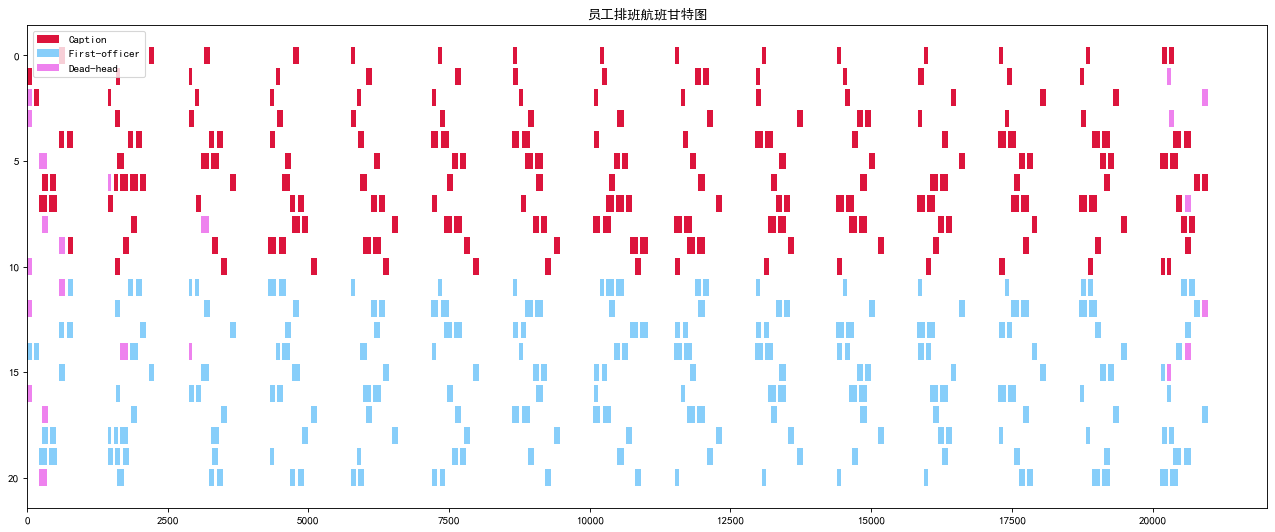

In [21]:
rv.draw_ef_gantt(save='results/q2_a.png')

In [1]:
df_a = rv.get_results_df_a()
df_a

NameError: name 'rv' is not defined

In [ ]:
df_a.to_csv('results/q2_a_UnconveredFlights.csv', index=0)

In [ ]:
df_b = rv.get_results_df_b()
df_b

In [ ]:
df_b.to_csv('results/q2_a_CrewRosters.csv', index=0)